# **Pepper Bell Disease Classification**

Dataset used: https://www.kaggle.com/datasets/arjuntejaswi/plant-village

### **Loading the module and datas**

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [1]:
#constants
IMAGE_SIZE=256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 100
FILE_PATH="mine"

In [6]:
#copying only the necessary datasets . doing only Pepper bell
!mkdir "mine"
!cp -r "../input/aihub-healthy/" "/kaggle/working/mine"
!cp -r "../input/aihub-powderymildew/" "/kaggle/working/mine"
!cp -r "../input/bacterial-spot/" "/kaggle/working/mine"
!cp -r "../input/pepmov/" "/kaggle/working/mine"
!cp -r "../input/pepper-anth/train/anthracnose/" "/kaggle/working/mine"
!cp -r "../input/pepper-anth/train/healthy" "/kaggle/working/mine"


mkdir: cannot create directory ‘mine’: File exists


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=FILE_PATH,
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)

Found 5261 files belonging to 6 classes.


In [4]:
CROP_SIZE = (256,256)
NUM_BOXES=5
image = tf.random.normal(shape=(
  BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS) )
boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,maxval=BATCH_SIZE, dtype=tf.int32)
output = tf.image.crop_and_resize(image,boxes,box_indices, CROP_SIZE)
output.shape
print(image)

tf.Tensor(
[[[[-7.43461788e-01  2.74481320e+00  3.28150272e-01]
   [ 8.18973005e-01  7.35491235e-03  9.92147028e-01]
   [ 9.72802043e-01 -6.48093283e-01 -3.67642306e-02]
   ...
   [ 9.22245860e-01  5.27950287e-01 -7.68069208e-01]
   [-2.40145779e+00 -1.23413372e+00 -1.07270706e+00]
   [-7.42618978e-01 -3.82047057e-01  3.95664126e-01]]

  [[-3.56950372e-01  1.00240633e-01 -3.84846479e-02]
   [-2.81140745e-01  1.62740970e+00  1.25790805e-01]
   [-1.43745852e+00 -8.42063129e-03  1.30539415e-02]
   ...
   [ 8.27372730e-01  9.20381308e-01 -1.82601762e+00]
   [-2.83953130e-01 -2.04573289e-01  7.00169206e-01]
   [-1.38137639e+00  7.44418025e-01 -1.27752554e+00]]

  [[ 2.59499192e-01  6.41625881e-01  5.56892991e-01]
   [ 1.13862252e+00  4.31611568e-01 -2.16828012e+00]
   [ 9.80297802e-04  6.51995614e-02  1.29332173e+00]
   ...
   [ 6.89555049e-01  5.49047649e-01  1.69239238e-01]
   [-1.71487615e-01 -3.70993614e-01  1.26164794e+00]
   [ 1.73169816e+00 -5.80794156e-01 -1.39432979e+00]]

  ...

 

In [5]:
class_names = dataset.class_names
class_names

['aihub-healthy',
 'aihub-powderymildew',
 'anthracnose',
 'bacterial-spot',
 'healthy',
 'pepmov']

### **Data Visualization**

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


(32, 256, 256, 3)
[1 0 1 0 0 1 0 0 0 4 1 3 1 2 5 1 2 3 2 2 1 5 4 4 3 3 5 2 0 2 3 1]


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


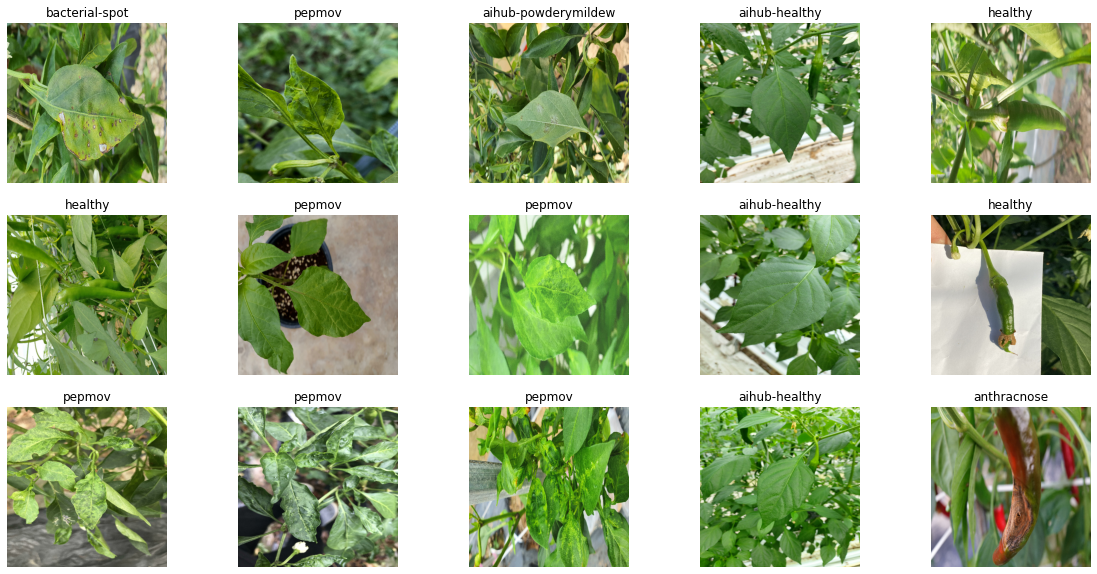

In [7]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### **Train Test Split**

In [7]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)

  
    train_ds = ds.take(train_size)    
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds ,test_ds, valid_ds
    

In [8]:
train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)
    

In [9]:
print(len(train_ds))
print(len(test_ds))
print(len(valid_ds))

132
17
16


In [10]:
# performance improving by both using CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### **Image Preprocessing**

In [11]:
rescale_and_resize=tf.keras.Sequential([
    #layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.CenterCrop(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
    
])

In [13]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

### **Building a Model**

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6


model = models.Sequential([
    rescale_and_resize,
   # data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [14]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [15]:
#model training
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1,
    epochs=100
    
)

Epoch 1/100


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

131/132 [============================>.] - ETA: 0s - loss: 1.6998 - accuracy: 0.2493

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

132/132 [==============================] - 584s 2s/step - loss: 1.6978 - accuracy: 0.2505 - val_loss: 1.4908 - val_accuracy: 0.3887
Epoch 2/100
132/132 [==============================] - 4s 33ms/step - loss: 1.3692 - accuracy: 0.4387 - val_loss: 1.1760 - val_accuracy: 0.5117
Epoch 3/100
132/132 [==============================] - 4s 33ms/step - loss: 1.1504 - accuracy: 0.5395 - val_loss: 0.9430 - val_accuracy: 0.6133
Epoch 4/100
132/132 [==============================] - 4s 34ms/step - loss: 0.9251 - accuracy: 0.6418 - val_loss: 0.7977 - val_accuracy: 0.6953
Epoch 5/100
132/132 [==============================] - 4s 32ms/step - loss: 0.8278 - accuracy: 0.6887 - val_loss: 0.5851 - val_accuracy: 0.7715
Epoch 6/100
132/132 [==============================] - 4s 33ms/step - loss: 0.7188 - accuracy: 0.7285 - val_loss: 0.6029 - val_accuracy: 0.7754
Epoch 7/100
132/132 [==============================] - 4s 32ms/step - loss: 0.6220 - accuracy: 0.7637 - val_loss: 0.6789 - val_accuracy: 0.7207
Epoc

In [16]:
scores = model.evaluate(test_ds)
scores

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

17/17 [==============================] - 313s 20ms/step - loss: 0.4736 - accuracy: 0.9048


[0.47363778948783875, 0.9047619104385376]

### **Plotting Model Accuracy**

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

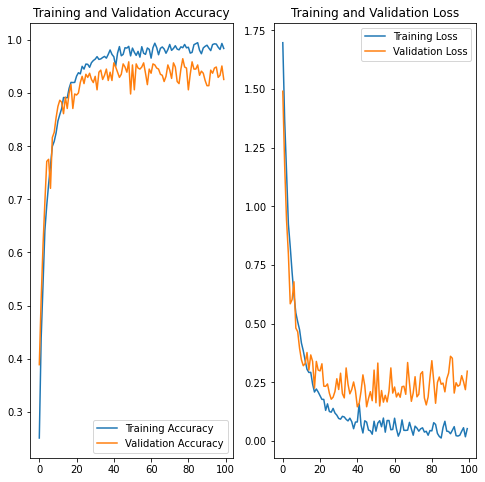

In [18]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Running prediction on a sample image**

first image to predict
actual label: pepmov
predicted label: pepmov


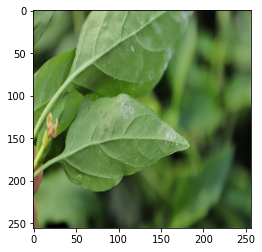

In [19]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
   
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    break

### **Predictions**

In [20]:
def predict_pepper_bell_diseases(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
  

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

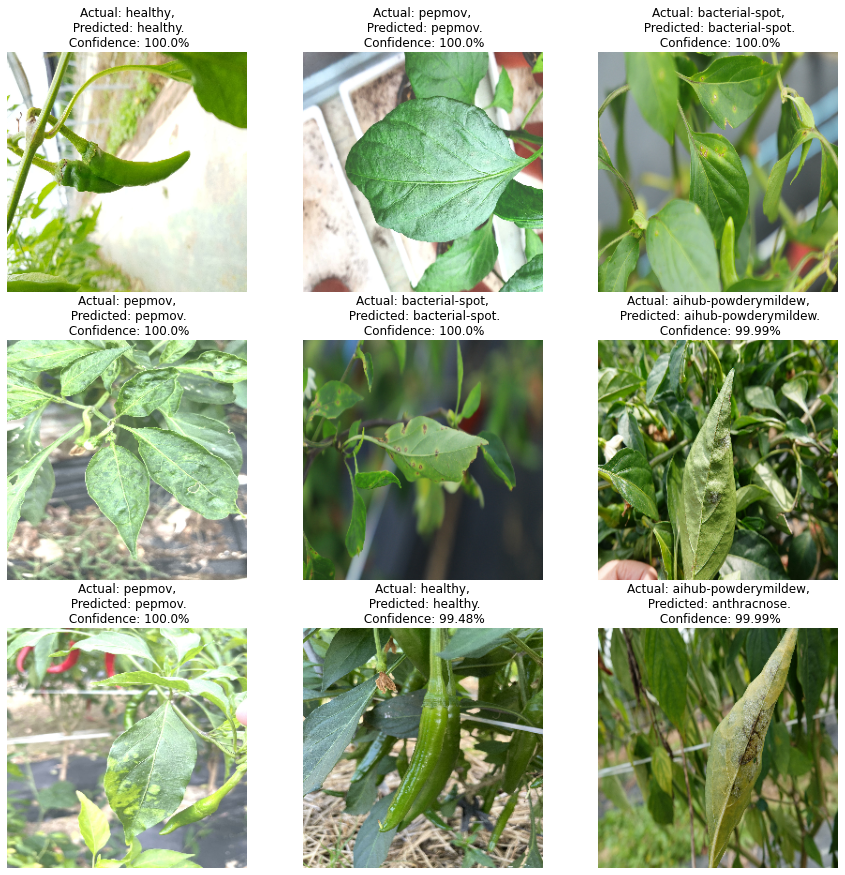

In [21]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_pepper_bell_diseases(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### **Saving the Model**

In [ ]:
!mkdir models
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/bell_pepper_{model_version}")

In [ ]:
model.save("anth_CenterCrop.h5")

In [ ]:
os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'anth_CenterCrop.h5')

#### **THE END :)**